# Comparison between interests generation methods in:
### score in link prediction and macro homophily metrics

In [1]:
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph
import tensorflow as tf
import networkx as nx
from scipy.spatial import distance
import itertools as IT
import pandas as pd

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
EPSILON = 1E-5
METRIC_NAMES = ['ratio', 'sub', 'like']
def homophily_metrics(similarity_edges, similarity_nonedges):
    return {
        'ratio': np.mean(similarity_edges) / np.mean(similarity_nonedges),
        'sub': np.mean(similarity_edges) - np.mean(similarity_nonedges),
        'like': np.sum(np.log(similarity_edges + EPSILON)) + np.sum(np.log(1 - similarity_nonedges + EPSILON)) ,
    }

In [4]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            #print(G.nodes[i]['interests'], emb[i])
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 5000)

In [5]:
def evaluate_metrics(graph, emb):
    '''
    Returns the three metrics for si and so defined in homophily_metrics function
    '''
    # building the graph
    for i in graph.nodes:
        graph.nodes[i]['interests'] = emb[int(i)]
        
    # calculating si and so
    output = {}
    si = sim_in(graph)
    so = sim_out(graph, 5000)
    output['si'] = round(si, 4)
    output['so'] = round(so, 4)
    for name, metric in homophily_metrics(si, so).items():
        output[name] = round(metric, 4)

    return output

In [6]:
def evaluate_score(graph, emb):
    '''
    Evaluetes the score in link prediction
    '''
    # creating X and y concatenating embeddings of the two linked nodes (y=1)
    X = []
    y = []
    for u, v in graph.edges():
        arr_u = list(emb[int(u)])
        arr_v = list(emb[int(v)])
        X.append(arr_u + arr_v)
        y.append(1)
        
    # adding no-linked nodes to X and y (y=0)
    missing = [pair for pair in IT.combinations(graph.nodes(), 2) if not graph.has_edge(*pair)]
    import random
    random.seed(42)
    no_edges = random.choices(missing, k=len(graph.edges()))
    for u, v in no_edges:
        arr_u = list(emb[int(u)])
        arr_v = list(emb[int(v)])
        X.append(arr_u + arr_v)
        y.append(0)
        
    # testing
    from sklearn.utils import shuffle
    X, y = shuffle(X, y, random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)
    # Create one-vs-rest logistic regression object
    clf = LogisticRegression(random_state=0, multi_class='ovr')
    # Train model
    model = clf.fit(X_train, y_train)
    
    return model.score(X_test, y_test)

In [33]:
def draw_emb(emb, title='', row=False):
    '''
    NB only for 2d embeddings
    params: dict of parameters for title
    '''
    nodes = [_ for _ in range(len(emb))]
    x_plot = [emb[_, 0] for _ in range(len(emb))]
    y_plot = [emb[_, 1] for _ in range(len(emb))]
    if row:
        row.scatter(x_plot, y_plot, linewidths=10)
        row.set_title(title)
    if not row:
        fig, ax = plt.subplots()
        ax.scatter(x_plot, y_plot, linewidths=10)
        for _ in range(len(nodes)):
            ax.annotate(nodes[_], (x_plot[_], y_plot[_]))
        ax.set_title(title)
    

### Import and display the graph

In [8]:
#graph_path = '../data/graph/wiki_vote/wiki_vote_edgelist.txt'
#graph_path = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'

G = read_graph(weighted=False, 
                   graph=graph_path,
                   directed=True)

NameError: name 'graph_path' is not defined

In [17]:
#G = nx.watts_strogatz_graph(20, 10, 0.1, seed=42)
G = nx.barabasi_albert_graph(100, m=2)
graph_path = '../../local/MNMF/data/wattsstr/wattsstr.txt'
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1
nx.write_edgelist(G,graph_path, data=False)

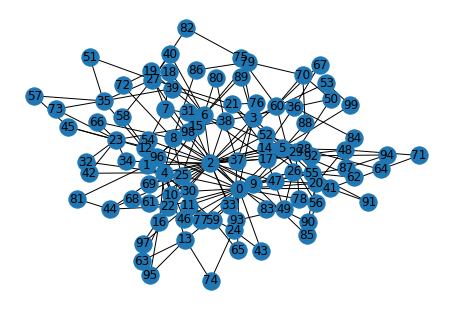

In [18]:
nx.draw(G, with_labels = True)
plt.show()

In [19]:
def graph_analysis(graph_path):
    G = nx.read_edgelist(graph_path)
    print('avg clustering coeff ', nx.average_clustering(G))
    print('numb of connected components: ', (nx.number_connected_components(G)))
    print('Assortativity: ', nx.degree_assortativity_coefficient(G))

    degree = np.array(list(dict(G.degree).values()))

    plt.figure(figsize=(9,7))
    plt.hist(degree, bins=100, normed=True)

    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.xlabel('Degree', fontsize=17)
    plt.ylabel('$P(k)$', fontsize=17)
    plt.show()

avg clustering coeff  0.14064436403061192
numb of connected components:  1
Assortativity:  -0.16189100513167973


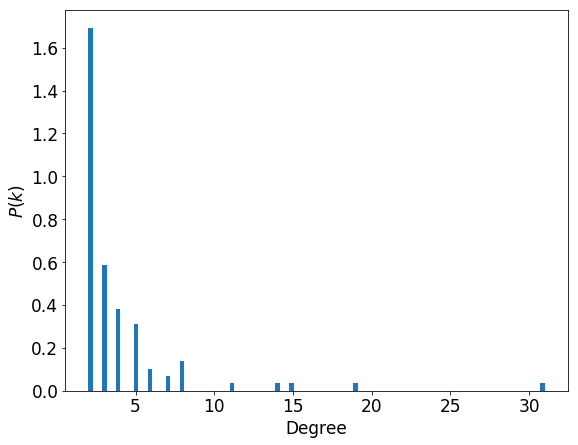

In [20]:
graph_analysis(graph_path)

In [21]:
# global values
topics = 2

### learning interests via tensorflow implementation

In [22]:
%%time
tf.reset_default_graph()
tf_emb = n2i_nx_graph(nx_graph=G, seed=10, 
                   window_size=10,
                   walk_length=80,
                   num_walks=10,
                   dimensions=topics,
                   p=0.1,
                   q=10,
                   beta=10,
                   alpha_value=0.5,
                   beta_value=2.,
                   prior='beta'
                   )

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Making walks... Done, T=0.50
Mapping Walk Names... prior:  0.5 2.0
beta:  10
CPU times: user 8.99 s, sys: 2.48 s, total: 11.5 s
Wall time: 5.32 s


In [ ]:
p = 1
q = 1
beta = [0.1, 1, 10]
prior = 'beta'
# if prior is beta:
alpha_prior_value = [0.5, 2.]
beta_prior_value = [0.5, 2.]

result = []
nrows = len(alpha_prior_value)*len(beta_prior_value)*len(beta)
fig, axes = plt.subplots(nrows, 1)

for row in axes:
    for b in beta:
        for av in alpha_prior_value:
            for bv in beta_prior_value:
                tf.reset_default_graph()
                tf_emb = n2i_nx_graph(nx_graph=G, 
                                       seed=10, 
                                       window_size=10,
                                       walk_length=80,
                                       num_walks=10,
                                       dimensions=topics,
                                       p=p,
                                       q=q,
                                       beta=b,
                                       alpha_value=av,
                                       beta_value=bv,
                                       prior=prior)
                
                result.append([b, av, bv, evaluate_metrics(graph=G, emb=tf_emb)])
                title = 'beta:'+str(b)+' prior_alpha: '+str(av)+' prior_beta: '+str(bv)
                draw_emb(row=row, emb=tf_emb, title=title)
plt.show()

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 0.5
beta:  0.1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 2.0
beta:  0.1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 0.5
beta:  0.1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 2.0
beta:  0.1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 0.5
beta:  1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 2.0
beta:  1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 0.5
beta:  1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 2.0
beta:  1
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 0.5
beta:  10
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 2.0
beta:  10
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 0.5
beta:  10
Making walks... Done, T=0.01
Mapping Walk Names... prior:  2.0 2.0
beta:  10
Making walks... Done, T=0.01
Mapping Walk Names... prior:  0.5 0.5
beta:  0.

In [37]:
result

[]

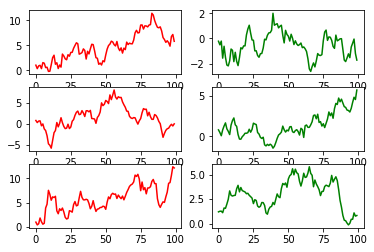

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def main():
    nrows = 3
    fig, axes = plt.subplots(nrows, 2)

    for row in axes:
        x = np.random.normal(0, 1, 100).cumsum()
        y = np.random.normal(0, 0.5, 100).cumsum()
        plot(row, x, y)

    plt.show()

def plot(axrow, x, y):
    axrow[0].plot(x, color='red')
    axrow[1].plot(y, color='green')

main()

In [ ]:
p = [1]
q = [1]
beta = [0.1, 1, 10]
prior = 'half_norm'
# if prior is half norm
mean = []
sigma = []

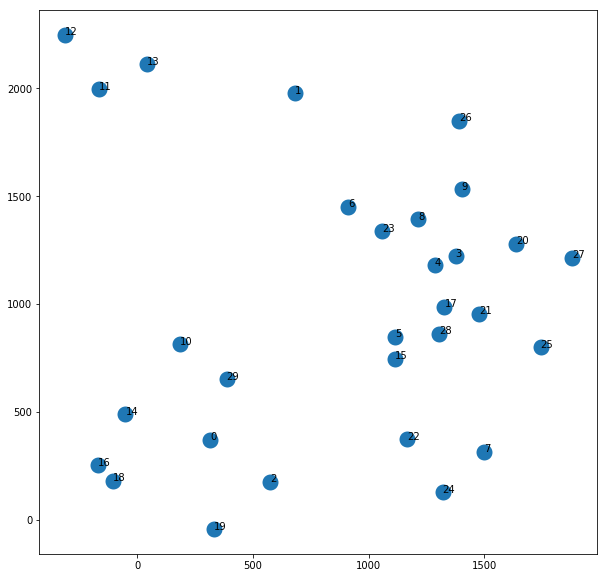

In [59]:
# alpha_v 0.5 beta_v 2. beta 10
draw_emb(tf_emb)

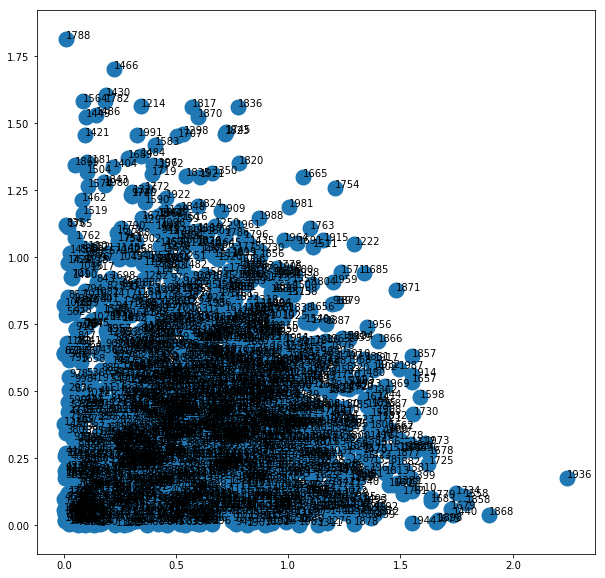

In [6]:
# alpha_v 0.5 beta_v 0.5 beta 10
draw_emb(tf_emb)

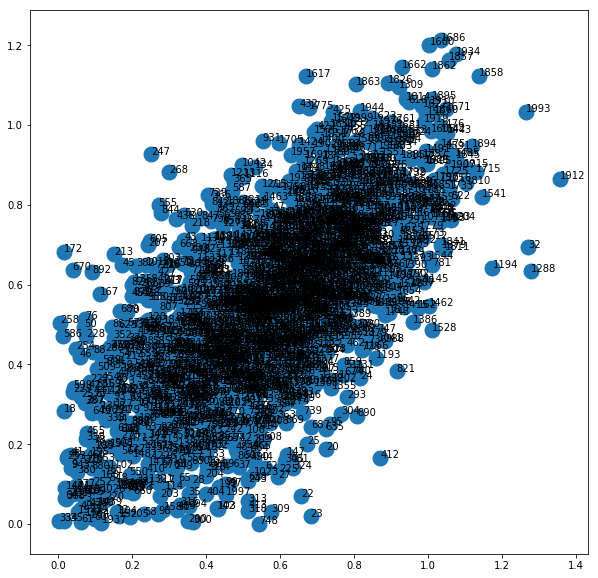

In [9]:
# alpha_v 0.5 beta_v 20 beta 1
draw_emb(tf_emb)

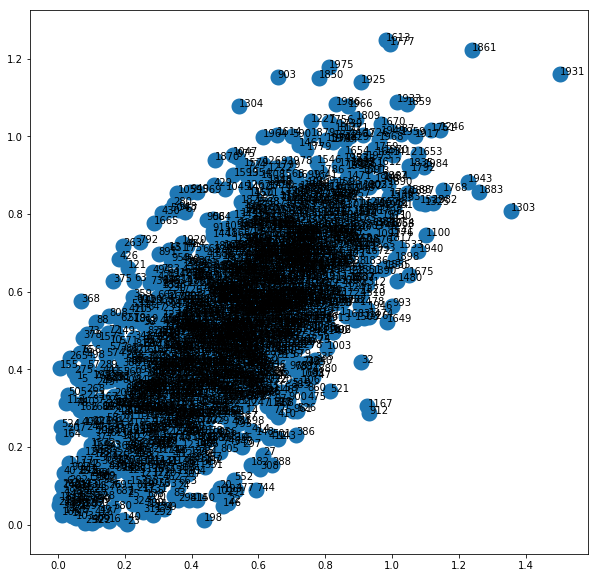

In [15]:
# alpha 2. 
draw_emb(tf_emb)

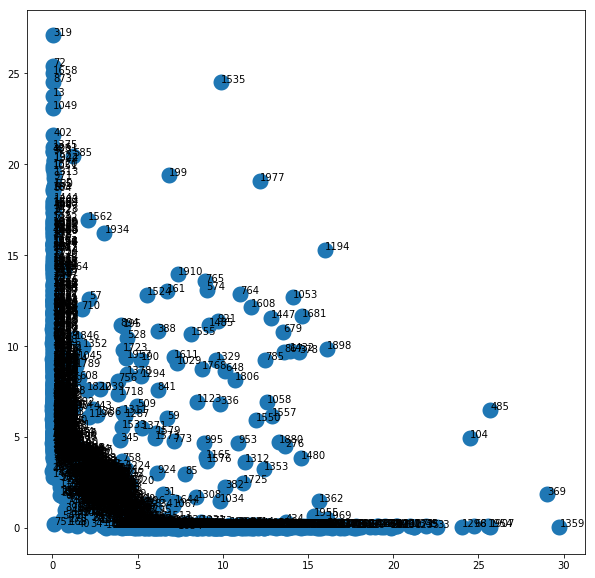

In [12]:
# half norm with high variance
draw_emb(tf_emb)

In [18]:
evaluate_score(G, tf_emb)

0.53171875

### defining the random uniform generation of interests

In [38]:
def random_emb(nr_nodes, nr_dim):
    r_emb = [0 for _ in range(nr_nodes)]
    for n in range(nr_nodes):
        r_emb[n] = np.random.rand(nr_dim)
    return np.array(r_emb)

In [39]:
nr_nodes, nr_dim = tf_emb.shape
r_emb = random_emb(nr_nodes, nr_dim)

In [40]:
evaluate_score(G, r_emb)

0.49375

In [42]:
#draw_emb(r_emb)

## SKIP THIS UNLESS YOU HAVE ALREADY RUN M NMF FROM TERMINAL

# ---------------------------------------------------------------------------------------

### M NMF

run mnmf from terminal and test the result

In [ ]:
#!cd .. ; cd .. ; cd local ; cd MNMF; python3 src/main.py --input ./data/lesmiserables/lesmiserables_edgelist.txt

In [27]:
emb_file = '../../local/MNMF/output/embeddings/wattsstr.csv'
m_df = pd.read_csv(emb_file)
m_emb = m_df.values

m_score = evaluate_score(G, m_emb)
m_metrics = evaluate_metrics(G, m_emb)

{'like': -1.2766, 'ratio': 1.2345, 'si': 0.8086, 'so': 0.655, 'sub': 0.1536}

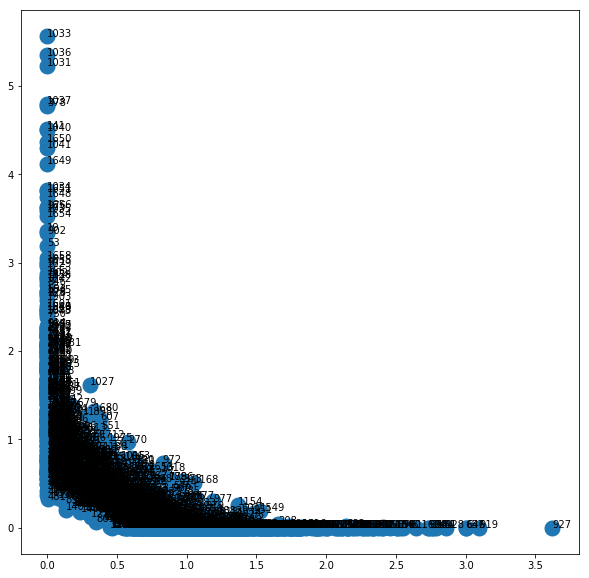

In [28]:
# alpha 0 beta 0 eta 1 dim 10
draw_emb(m_emb)
m_metrics

In [38]:
m_score

0.55171875

In [63]:
# alpha 0 beta 0 eta 5 dim 10
#draw_emb(m_emb)
m_metrics

{'like': -0.8728, 'ratio': 2.5567, 'si': 0.5259, 'so': 0.2057, 'sub': 0.3202}

In [60]:
# alpha .05 beta .05 eta 5 dim 10
#draw_emb(m_emb)
m_metrics

{'like': -0.8098, 'ratio': 2.5456, 'si': 0.5746, 'so': 0.2257, 'sub': 0.3489}

{'like': -1.2308, 'ratio': 1.2644, 'si': 0.8066, 'so': 0.6379, 'sub': 0.1687}

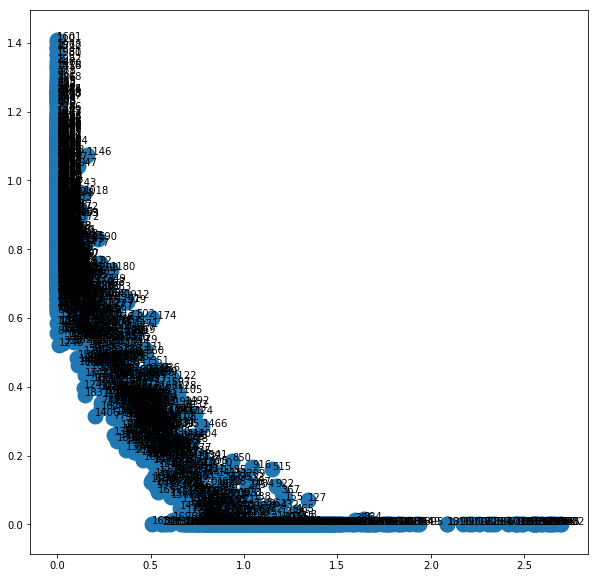

In [52]:
# alpha .05 beta .05 eta 5
draw_emb(m_emb)
m_metrics

{'like': -1.2279, 'ratio': 1.2623, 'si': 0.8004, 'so': 0.6341, 'sub': 0.1663}

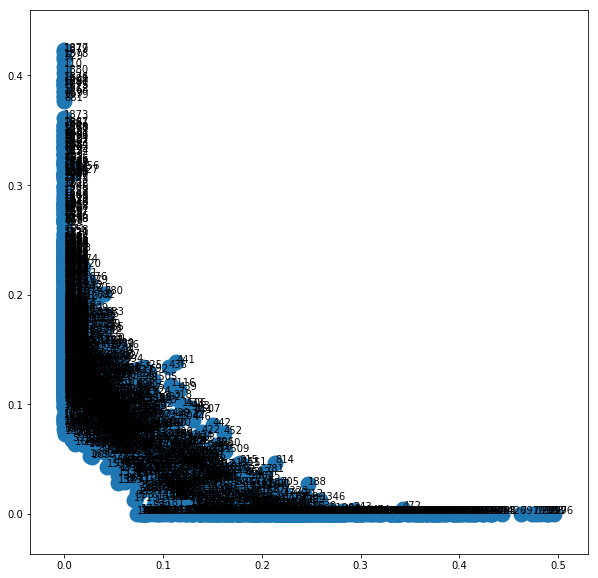

In [49]:
# alpha 5 beta 5 eta 5
draw_emb(m_emb)
m_metrics

{'like': -1.1608, 'ratio': 1.3084, 'si': 0.7888, 'so': 0.6029, 'sub': 0.1859}

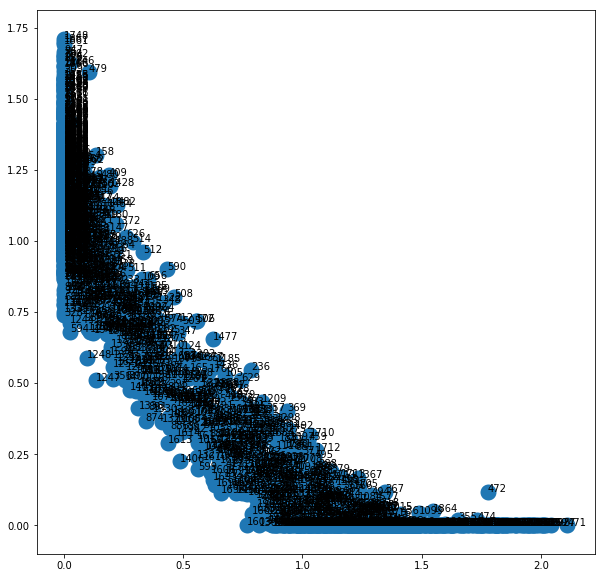

In [47]:
# alpha 0 beta 5 eta 5
draw_emb(m_emb)
m_metrics

{'like': -1.3085, 'ratio': 1.2134, 'si': 0.8071, 'so': 0.6652, 'sub': 0.1419}

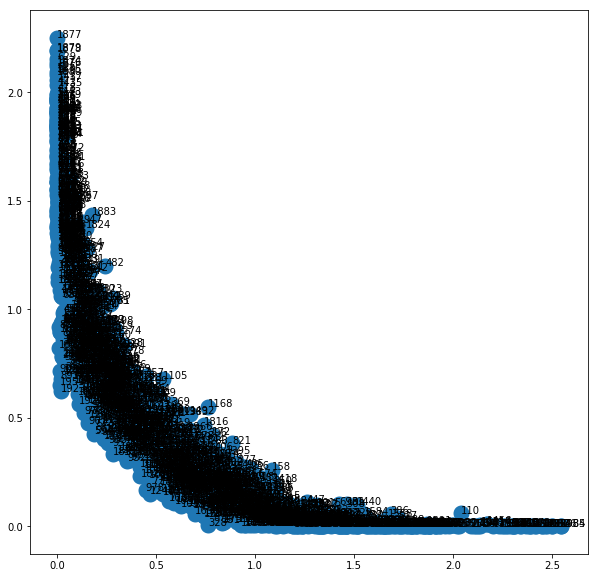

In [45]:
# alpha 0 beta 0 eta 5
draw_emb(m_emb)
m_metrics

{'like': -1.2696, 'ratio': 1.2303, 'si': 0.7963, 'so': 0.6472, 'sub': 0.1491}

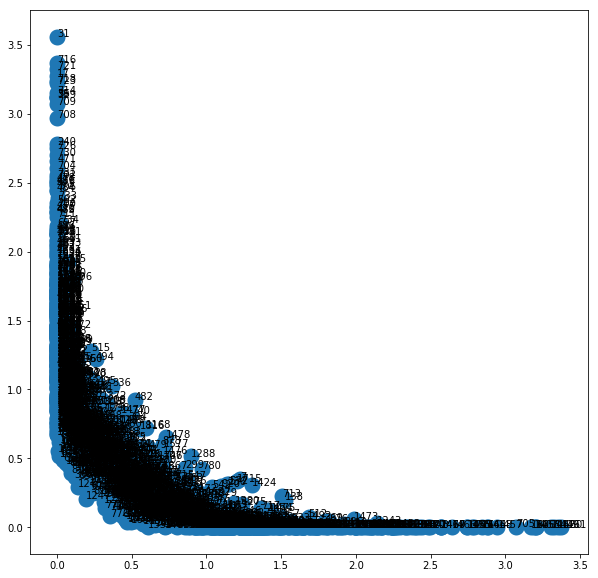

In [43]:
# alpha beta eta 0
draw_emb(m_emb)
m_metrics

In [28]:
# beta 0 eta 5 alpha 0
m_metrics

{'like': -1.2206, 'ratio': 1.2348, 'si': 0.7474, 'so': 0.6052, 'sub': 0.1421}

In [27]:
# beta 0 eta 0.5 alpha 0
m_metrics

{'like': -1.2206, 'ratio': 1.2348, 'si': 0.7474, 'so': 0.6052, 'sub': 0.1421}

In [25]:
# beta 0 eta 0 alpha 0
m_metrics

{'like': -1.187, 'ratio': 1.2603, 'si': 0.7422, 'so': 0.5889, 'sub': 0.1533}

In [23]:
# beta 0.5
m_metrics

{'like': -1.0836, 'ratio': 1.3675, 'si': 0.7531, 'so': 0.5507, 'sub': 0.2024}

In [ ]:
# email data beta: 1
evaluate_metrics(les_graph, m_emb)

In [ ]:
# beta 0.1
evaluate_metrics(les_graph, m_emb)

In [ ]:
# beta 1
evaluate_metrics(les_graph, m_emb)

In [ ]:
# beta 0.05
evaluate_metrics(les_graph, m_emb)

In [ ]:
# beta 0.05
evaluate_metrics(les_graph, m_emb)

# ----------------------------------------------------------------------------------

### Propagation method for generating interests

In [14]:
def propag_emb(G, nr_nodes, nr_topics):
    '''
    generates interests with the propagation method starting from "n" nodes
    '''
    # INITIALIZE
    np.random.seed(420)
    for i in list(G.nodes):
        interests = np.random.dirichlet(np.ones(nr_topics)*1./nr_topics)
        G.nodes[i]['interests'] = interests
    
    # SELECT INFLUENCERS
    # start with a random node
    influencers = [np.random.choice(G.nodes)]

    for i in range(14):
        # calculate distances to current influencers
        sp = {i: nx.shortest_path(G, i) for i in influencers}
        distances = np.array([list(len(sp[j][i]) for j in influencers) for i in G.nodes()])
        # select the node fartest from all influencers
        influencers.append(distances.min(axis=1).argmax()) 
      
    # PROPAGATION STEP
    for c in range(10000):
        i = np.random.choice(nr_nodes)
        interests_i = G.nodes[i]['interests']
        #print(G.nodes[0]['interests'])
        lr = 0.5 if i in influencers else 0.01
        #lr = 0.1
        for j in list(G.neighbors(i)):
            if j in influencers:
                continue
            interests_j = G.nodes[j]['interests']
            interests_j += interests_i * lr
            interests_j /= interests_j.sum()
            G.nodes[j]['interests'] = interests_j
            #print(interests_j)

        if c%1000 == 0:
            si = sim_in(G)
            so = sim_out(G, 5000)
            #print (si, so, si/so)

    # preparing matrix
    prop_emb = [G.nodes[_]['interests'] for _ in range(nr_nodes)]
    return np.array(prop_emb)

In [15]:
nr_nodes, nr_topics = tf_emb.shape
p_emb = propag_emb(G, nr_nodes, nr_topics)

NameError: name 'tf_emb' is not defined

In [64]:
evaluate_score(G, p_emb)

0.4807692307692308

In [65]:
p_emb

array([[0.58294571, 0.41705429],
       [0.765502  , 0.234498  ],
       [0.13136525, 0.86863475],
       [0.86500618, 0.13499382],
       [0.48765361, 0.51234639],
       [0.94092734, 0.05907266],
       [0.0943411 , 0.9056589 ],
       [0.02173687, 0.97826313],
       [0.13172709, 0.86827291],
       [0.59859223, 0.40140777],
       [0.23250786, 0.76749214],
       [0.54024831, 0.45975169],
       [0.54185724, 0.45814276],
       [0.38423403, 0.61576597],
       [0.09251868, 0.90748132],
       [0.30736529, 0.69263471],
       [0.39177222, 0.60822778],
       [0.10025881, 0.89974119],
       [0.07162364, 0.92837636],
       [0.02955769, 0.97044231],
       [0.40651905, 0.59348095],
       [0.03345384, 0.96654616],
       [0.09012659, 0.90987341],
       [0.58671236, 0.41328764],
       [0.07945473, 0.92054527],
       [0.83334936, 0.16665064],
       [0.94676698, 0.05323302],
       [0.10894226, 0.89105774],
       [0.94008237, 0.05991763],
       [0.14677771, 0.85322229]])

## Comparing all three methods

In [67]:
def compare_methods(graph, beta, p=0.1, q=10, nr_topics=2, prior='beta'):
    '''
    Comprare interests method creation
    '''
    nr_nodes = graph.number_of_nodes()
    
    tf.reset_default_graph()
    tf_emb = n2i_nx_graph(nx_graph=graph, seed=10, 
                   window_size=10,
                   walk_length=80,
                   num_walks=30,
                   dimensions=nr_topics,
                   p=p,
                   q=q,
                   beta=beta,
                   prior=prior
                   )
    tf_score = evaluate_score(graph, tf_emb)
    tf_metrics = evaluate_metrics(graph, tf_emb)
    p_emb = propag_emb(graph, nr_nodes, nr_topics)
    p_score = evaluate_score(graph, p_emb)
    p_metrics = evaluate_metrics(graph, p_emb)
    r_emb = random_emb(nr_nodes, nr_topics)
    r_score = evaluate_score(graph, r_emb)
    r_metrics = evaluate_metrics(graph, r_emb)

    
    
    print('Tf score: ', round(tf_score, 3), ' Propag score: ', round(p_score, 3), ' Random score: ', 
          round(r_score, 3))
    print('Tensfl metrics: ', tf_metrics, '\nPropag metrics: ', p_metrics, '\nRandom metrics: ', r_metrics)


    

In [68]:
# graph2vec implementation of random walk
compare_methods(G, nr_topics=10, beta=0.1, p=10, q=0.1, prior='half_norm')

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Making walks... Done, T=0.40
Mapping Walk Names... beta:  0.1
[8.87433466e-10 6.25948120e-05 3.70526043e-01 2.68082239e-02
 9.49502939e-02 6.37536545e-03 1.26433028e-06 1.19318272e-01
 3.81957942e-01 1.85788748e-11]
[1.86742360e-06 2.48944182e-02 1.84471644e-09 2.56321851e-02
 7.70695040e-06 3.09830386e-01 1.50882263e-01 1.92623567e-08
 8.87904024e-03 4.79872112e-01]
[1.89171867e-01 2.47061559e-18 1.13553191e-04 1.69196201e-05
 7.23301118e-01 1.14141551e-05 2.78813581e-04 8.57271546e-02
 1.76072209e-05 1.36155255e-03]
[3.98175579e-04 3.06883497e-01 2.61544800e-01 1.03047164e-02
 3.27019727e-02 2.24488352e-03 4.44738411e-07 4.39132681e-02
 3.34025029e-01 7.98321274e-03]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02 1.35652086e-01 2.18580742e-07 3.26976298e-02
 5.22765252e-03 3.66235140e-05]
[3.39146718e-10 3.99457182e-02 1.23508681e-01 3.42290307e-02
 1.60157731e-01 5.97949830e-02 4.96938032e-07 3.97727572e-02
 5.41218974e-01 1.37162725e-03]
[1.89171867e-0

 1.51232419e-01 1.85783931e-09]
[8.87433466e-10 6.25948120e-05 3.70526043e-01 2.68082239e-02
 9.49502939e-02 6.37536545e-03 1.26433028e-06 1.19318272e-01
 3.81957942e-01 1.85788748e-11]
[0.00047991 0.00948603 0.12785423 0.02276446 0.03076733 0.23586749
 0.10784851 0.01003016 0.00231631 0.45258558]
[5.06003688e-02 5.79857425e-05 4.37785669e-01 2.33163026e-03
 1.37792143e-03 3.55325294e-01 1.28871051e-03 1.84970736e-17
 1.51232419e-01 1.85783931e-09]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02 1.35652086e-01 2.18580742e-07 3.26976298e-02
 5.22765252e-03 3.66235140e-05]
[0.00047991 0.00948603 0.12785423 0.02276446 0.03076733 0.23586749
 0.10784851 0.01003016 0.00231631 0.45258558]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.4

 9.71024358e-02 1.16163909e-04]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02 1.35652086e-01 2.18580742e-07 3.26976298e-02
 5.22765252e-03 3.66235140e-05]
[5.64934069e-04 7.92920070e-03 5.20725235e-01 8.15584993e-05
 1.57016527e-03 1.18262023e-02 2.62534179e-03 4.39377618e-01
 2.38165645e-03 1.29180878e-02]
[0.00203269 0.02323828 0.09486512 0.00947306 0.05244927 0.10950389
 0.12820592 0.01198728 0.00880599 0.5594385 ]
[5.64934069e-04 7.92920070e-03 5.20725235e-01 8.15584993e-05
 1.57016527e-03 1.182620

 2.66320273e-05 9.17288695e-06]
[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[1.32109993e-12 1.80872204e-04 3.54628231e-01 2.62375624e-02
 3.85662555e-01 2.33290779e-01 1.52515909e-29 2.35937745e-17
 9.72799803e-14 6.12507949e-14]
[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02 1.09965656e-10 1.39008273e-06 7.79272638e-05
 1.75538101e-01 1.99899739e-01]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[5.06003688e-02 5.79857425e-05 4.37785669e-01 2.33163026e-03
 1.37792143e-03 3.55325294e-01 1.28871051e-03 1.84970736e-17
 1.51232419e-01 1.85783931e-09]
[0.02043766 0.05156096 0.51974763 0.01425961 0.0225303  0.22978105
 0.02291404 0.01878272 0.09859495 0.00139107]
[0.01853822 0.00130615 0.33126271 0.0132503  0.11982249 0.18998542
 0.01016529 0.0274

[0.047274   0.01760325 0.42144627 0.00237291 0.00448201 0.33856728
 0.00198554 0.01118406 0.14132528 0.01375941]
[0.04841625 0.00275974 0.02777039 0.00120326 0.01183777 0.79410379
 0.00983817 0.00770732 0.02133049 0.07503283]
[2.73799576e-02 2.05654229e-03 2.12297215e-02 3.74304425e-04
 2.77365125e-03 4.46338035e-01 5.55681010e-03 4.16802101e-01
 3.47419045e-02 4.27469728e-02]
[4.95417878e-04 7.55033518e-03 5.28245725e-01 5.78624207e-05
 9.02849845e-04 1.00692864e-02 1.39796030e-03 4.42582732e-01
 1.58790697e-03 7.10992466e-03]
[0.00763662 0.0793573  0.16286969 0.01045577 0.14795369 0.19050324
 0.00623761 0.01231534 0.01094292 0.37172781]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[0.00161527 0.01076709 0.12876081 0.02092994 0.03053424 0.22486648
 0.10741715 0.01359563 0.00651533 0.45499805]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.7978863

[1.24685913e-03 1.08406569e-01 3.89000341e-01 5.84735034e-05
 1.04712108e-02 9.05853909e-02 3.91677782e-05 3.73633497e-01
 2.64345190e-02 1.23972156e-04]
[7.40448475e-09 2.56460306e-04 1.62599572e-01 1.17597567e-02
 4.21406651e-02 2.79511358e-03 1.64843951e-05 4.01490821e-01
 1.87049531e-01 1.91891588e-01]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[0.01862819 0.000768   0.23137303 0.00562716 0.01257192 0.1314015
 0.00103742 0.47110758 0.12610014 0.00138506]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[3.44516481e-03 5.00517060e-03 5.43162179e-01 3.62508680e-02
 5.77462115e-02 4.10959679e-02 4.38785478e-04 7.24313953e-02
 2.34621285e-01 5.80297209e-03]
[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02 1.09965656e-10 1.39008273e-06 7.79272638e

[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[3.64542662e-08 1.18762051e-03 1.19029381e-06 3.31888355e-05
 6.26692356e-09 5.65219889e-08 8.28088479e-05 1.16099159e-04
 1.07440542e-03 9.97504588e-01]
[8.87433466e-10 6.25948120e-05 3.70526043e-01 2.68082239e-02
 9.49502939e-02 6.37536545e-03 1.26433028e-06 1.19318272e-01
 3.81957942e-01 1.85788748e-11]
[3.64542662e-08 1.18762051e-03 1.19029381e-06 3.31888355e-05
 6.26692356e-09 5.65219889e-08 8.28088479e-05 1.16099159e-04
 1.07440542e-03 9.97504588e-01]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02

[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[5.86084885e-12 1.80882727e-02 4.54053679e-02 4.12806604e-07
 6.86204505e-02 2.85512905e-13 1.60362064e-01 7.84691956e-04
 5.10216235e-15 7.06738741e-01]
[4.83618278e-02 5.48496874e-02 2.20953138e-06 2.50003398e-27
 1.86772293e-03 1.95661456e-01 6.94510477e-01 3.65223421e-03
 4.61518478e-11 1.09438472e-03]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02 1.09965656e-10 1.39008273e-06 7.79272638e-05
 1.75538101e-01 1.99899739e-01]
[0.03251777 0.00399518 0.2975504  0.01919971 0.01086258 0.51668199
 0.00607118 0.01354081 0.05500601 0.04457437]
[0.03145956 0.19045754 0.0291967  0.00207051 0.02750666 0.53014411
 0.01584136 0.00091197 0.0102795  0.1621321 ]
[5.2

 9.72799803e-14 6.12507949e-14]
[6.50452225e-03 1.76279440e-03 5.84983613e-02 6.43299560e-04
 3.64540989e-03 5.02874096e-02 1.10483138e-03 8.08146605e-01
 6.39721264e-02 5.43463977e-03]
[1.32109993e-12 1.80872204e-04 3.54628231e-01 2.62375624e-02
 3.85662555e-01 2.33290779e-01 1.52515909e-29 2.35937745e-17
 9.72799803e-14 6.12507949e-14]
[1.04649654e-04 1.08913354e-03 1.59555056e-01 3.33463913e-02
 1.00284281e-02 3.41976548e-01 9.20804926e-02 5.01835980e-17
 5.75773267e-04 3.61243528e-01]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[8.87433466e-10 6.25948120e-05 3.70526043e-0

[0.03153625 0.0015805  0.20825328 0.01423022 0.02775474 0.51109247
 0.00599225 0.03483396 0.1220455  0.04268083]
[5.86084885e-12 1.80882727e-02 4.54053679e-02 4.12806604e-07
 6.86204505e-02 2.85512905e-13 1.60362064e-01 7.84691956e-04
 5.10216235e-15 7.06738741e-01]
[5.06003688e-02 5.79857425e-05 4.37785669e-01 2.33163026e-03
 1.37792143e-03 3.55325294e-01 1.28871051e-03 1.84970736e-17
 1.51232419e-01 1.85783931e-09]
[0.03654074 0.01291352 0.31723279 0.00770411 0.01540465 0.22444819
 0.15550987 0.09178199 0.13784627 0.00061786]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[0.02234773 0.00612177 0.28356814 0.00675679 0.09242258 0.19929153
 0.05427646 0.00629263 0.08496948 0.2439529 ]
[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[2.42737611e-05 4.54945592e-06 6.01402848e-01

 3.64835065e-02 7.37977141e-04]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[3.43314091e-04 2.00094435e-02 1.05253239e-01 2.60225590e-03
 4.11379836e-02 4.37633621e-02 6.86273973e-05 7.44506840e-01
 4.18229203e-02 4.92013959e-04]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[8.31437964e-10 3.25691927e-05 4.88451179e-02 3.50940248e-03
 1.36060972e-02 8.34405847e-04 1.77650334e-06 8.19144406e-01
 9.46202927e-02 1.94059313e-02]
[5.09149199e-02 8.01990627e-04 4.20004536e-03 3.02045586e-04
 1.52796153e-03 8.33192120e-01 9.85111377e-03 1.32470625e-02
 1.69983833e-02 6.89643572e-02]
[2.67759827e-04 7.15494498e-03 5.34043252e-01 3.68889306e-05
 4.58055365e-04 5.50114260e-03 8.53281038e-04 4.47415374e-01
 5.21913588e-04 3.74738824e-03]
[8.87433466e-10 6.25948120e-05 3.70526043e-0

 0.00192715 0.03491736 0.13735389 0.00814894]
[5.07408573e-05 1.99919180e-02 5.16326950e-01 5.28262093e-04
 7.11841788e-03 2.73191749e-02 8.39727537e-03 3.77155806e-01
 3.40368765e-03 3.97077682e-02]
[6.93401627e-03 3.18980411e-03 6.10583020e-02 6.44536944e-04
 2.41631466e-03 5.37356378e-02 3.23199358e-03 7.90340444e-01
 6.41389255e-02 1.43100254e-02]
[0.00141066 0.01839923 0.42267566 0.02475453 0.04490891 0.03408308
 0.00904523 0.26384798 0.17785177 0.00302295]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[8.87433466e-10 6.25948120e-05 3.70526043e-01 2.68082239e-02
 9.49502939e-02 6.37536545e-03 1.26433028e-06 1.19318272e-01
 3.81957942e-01 1.85788748e-11]
[3.01030327e-09 1.20917551e-04 2.47738127e-01 1.79185960e-02
 6.3825117

[7.87929034e-04 6.53837855e-02 3.13826036e-01 6.32917131e-03
 9.93469183e-02 1.18029930e-01 1.85002045e-04 3.72204756e-01
 2.23509196e-02 1.55555282e-03]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02 1.35652086e-01 2.18580742e-07 3.26976298e-02
 5.22765252e-03 3.66235140e-05]
[1.32109993e-12 1.80872204e-04 3.54628231e-01 2.62375624e-02
 3.85662555e-01 2.33290779e-01 1.52515909e-29 2.35937745e-17
 9.72799803e-14 6.12507949e-14]
[2.38196512e-02 3.25693774e-01 2.38774043e-01 3.12707889e-03
 8.22257466e-03 1.67854721e-01 1.71526824e-02 1.11440152e-01
 1.03687327e-01 2.27997236e-04]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[0.02432307 0.00200106 0.21157538 0.0012413  0.00233821 0.17222759
 0.00095076 0.48067607 0.09931418 0.00535239]
[3.98146140e-04 7.10195129e-02 2.51154057e-01 1.99124166e-05
 7.34689678e-03 5.66813020e-02 2.54299020e-05 5.78584572

 9.90414921e-02 2.31607446e-04]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[1.20730022e-08 4.01749161e-04 8.67900900e-02 6.27707730e-03
 2.28056726e-02 1.49021211e-03 2.72419763e-05 4.44839786e-01
 1.12774911e-01 3.24593248e-01]
[5.06003688e-02 5.79857425e-05 4.37785669e-01 2.33163026e-03
 1.37792143e-03 3.55325294e-01 1.28871051e-03 1.84970736e-17
 1.51232419e-01 1.85783931e-09]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[4.83618278e-02 5.48496874e-02 2.20953138e-06 2.50003398e-27
 1.86772293e-03 1.95661456e-01 6.94510477e-01 3.65223421e-03
 4.61518478e-11 1.09438472e-03]
[5.86084885e-12 1.80882727e-02 4.54053679e-02 4.12806604e-07
 6.86204505e-02 2.85512905e-13 1.60362064e-01 7.84691956e-04
 5.10216235e-15 7.06738741e-01]
[4.10628715e-08 1.80367833e-01 6.29565710e-0

[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[1.07045395e-02 6.54516890e-01 1.31754770e-01 2.65649677e-03
 8.44607059e-03 7.58968091e-02 3.35259897e-02 2.27282435e-02
 5.93119920e-02 4.58199068e-04]
[1.04649654e-04 1.08913354e-03 1.59555056e-01 3.33463913e-02
 1.00284281e-02 3.41976548e-01 9.20804926e-02 5.01835980e-17
 5.75773267e-04 3.61243528e-01]
[5.06003688e-02 5.79857425e-05 4.37785669e-01 2.33163026e-03
 1.37792143e-03 3.55325294e-01 1.28871051e-03 1.84970736e-17
 1.51232419e-01 1.85783931e-09]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[4.83618278e-02 5.48496874e-02 2.20953138e-06 2.50003398e-27
 1.86772293e-03

[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02 1.09965656e-10 1.39008273e-06 7.79272638e-05
 1.75538101e-01 1.99899739e-01]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715e-01
 1.40687081e-04 1.15218535e-03]
[0.04771729 0.00418028 0.0278562  0.0011654  0.01453932 0.79080441
 0.00975821 0.01663381 0.01675072 0.07059437]
[0.00054199 0.01973427 0.12726628 0.02369008 0.02552461 0.24859704
 0.10669393 0.0061847  0.00158324 0.44018386]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[0.00138813 0.00515923 0.07828817 0.00521563 0.0676297  0.05483012
 0.03847441 0.02039055 0.02560347 0.70302058]
[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[4.27470302e-05 6.29144500e-03 5.40647089e-01

[7.17362509e-12 1.49749612e-06 4.12943188e-04 1.32065612e-07
 1.38767255e-03 7.79788634e-10 3.74074999e-11 9.45695918e-01
 5.25017479e-02 8.75949181e-08]
[0.01190349 0.00820455 0.18472739 0.00531006 0.09818385 0.12729836
 0.07135537 0.00122426 0.03672638 0.45506628]
[5.75354246e-04 6.40538273e-03 5.29966236e-01 1.67026718e-05
 2.04826753e-04 9.19286873e-03 5.32602842e-04 4.49212136e-01
 1.11438237e-03 2.77950768e-03]
[4.83618278e-02 5.48496874e-02 2.20953138e-06 2.50003398e-27
 1.86772293e-03 1.95661456e-01 6.94510477e-01 3.65223421e-03
 4.61518478e-11 1.09438472e-03]
[4.10628715e-08 1.80367833e-01 6.29565710e-01 7.42266529e-08
 1.64521306e-02 1.35652086e-01 2.18580742e-07 3.26976298e-02
 5.22765252e-03 3.66235140e-05]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[4.83618278e-02 5.48496874e-02 2.20953138e-06 2.50003398e-27
 1.86772293e-03 1.95661456e-01 6.94510477e-01 3.65223421

[0.01241099 0.00462002 0.24063176 0.01009962 0.14838098 0.17303465
 0.03918276 0.00787493 0.04573164 0.31803266]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[5.92110300e-04 6.49365492e-03 5.27810468e-01 1.64144875e-05
 5.50377861e-04 9.48756699e-03 1.33011859e-03 4.45925001e-01
 1.28498391e-03 6.50930442e-03]
[8.87433466e-10 6.25948120e-05 3.70526043e-01 2.68082239e-02
 9.49502939e-02 6.37536545e-03 1.26433028e-06 1.19318272e-01
 3.81957942e-01 1.85788748e-11]
[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[1.04649654e-04 1.08913354e-03 1.59555056e-01 3.33463913e-02
 1.00284281e-02 3.41976548e-01 9.20804926e-02 5.01835980e-17
 5.75773267e-04 3.61243528e-01]
[4.27470302e-05 6.29144500e-03 5.40647089e-01 4.00949680e-16
 1.86164905e-07 1.55665267e-10 3.11945523e-04 4.51413715

[1.00247613e-03 2.36405884e-01 7.49188422e-02 4.58114607e-03
 1.70377713e-02 8.19499053e-03 1.20362168e-02 5.50154616e-01
 9.55025144e-02 1.65541699e-04]
[0.04763392 0.01706879 0.41888706 0.00238464 0.00424878 0.34021248
 0.00207205 0.01025732 0.14223637 0.01499859]
[0.04763392 0.01706879 0.41888706 0.00238464 0.00424878 0.34021248
 0.00207205 0.01025732 0.14223637 0.01499859]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[0.00382175 0.00358396 0.24734653 0.01420397 0.0202399  0.02715948
 0.00056871 0.56357971 0.11658862 0.00290737]
[0.00382175 0.00358396 0.24734653 0.01420397 0.0202399  0.02715948
 0.00056871 0.56357971 0.11658862 0.00290737]
[5.06224143e-02 1.58824497e-03 1.06955088e-02 5.05969998e-04
 4.25528778e-03 8.29395954e-01 9.85739340e-03 6.59108307e-03
 1.72421407e-02 6.92460026e-02]
[9.40640814e-09 3.12935626e-04 6.36354643e-02 4.59543226e-03
 1.70442756e-02 1.0908510

[0.02201756 0.02112518 0.20610158 0.00797226 0.0025111  0.12005186
 0.19178871 0.37971004 0.04710867 0.00161304]
[0.01853326 0.00936473 0.61032092 0.0384606  0.00288249 0.26704135
 0.00314007 0.00336769 0.01979848 0.02709041]
[5.21024763e-02 1.90470650e-07 2.54430336e-09 2.07437563e-04
 1.85877384e-06 8.51227138e-01 1.00159831e-02 2.05133011e-27
 1.65435397e-02 6.99013731e-02]
[3.00380059e-02 8.70241809e-04 1.13078870e-02 1.86335558e-04
 1.49546537e-03 4.90681904e-01 6.44576170e-03 3.82195510e-01
 3.11392702e-02 4.56396181e-02]
[1.59572047e-02 2.09436377e-01 1.50436087e-01 1.40396313e-03
 3.56150090e-03 1.12281669e-01 1.10462608e-02 4.16886379e-01
 7.88439120e-02 1.46645323e-04]
[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02 1.09965656e-10 1.39008273e-06 7.79272638e-05
 1.75538101e-01 1.99899739e-01]
[0.0016992  0.01466794 0.08823324 0.00975596 0.05085877 0.11531041
 0.1314829  0.00784537 0.00516712 0.57497908]
[5.05954044e-02 1.53455755e-03 9.66966650e-03

[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[2.74031633e-06 1.39652532e-01 5.33443856e-01 5.27521831e-03
 3.30998976e-02 2.74905435e-01 5.48448254e-05 1.35296714e-02
 2.66320273e-05 9.17288695e-06]
[5.86084885e-12 1.80882727e-02 4.54053679e-02 4.12806604e-07
 6.86204505e-02 2.85512905e-13 1.60362064e-01 7.84691956e-04
 5.10216235e-15 7.06738741e-01]
[9.07440735e-03 1.30425271e-03 1.13154733e-02 6.89170617e-05
 1.50828801e-03 1.49122917e-01 1.97489931e-03 7.63899581e-01
 4.54323014e-02 1.62989628e-02]
[7.04533951e-11 9.29879476e-01 1.90458303e-02 4.28617558e-04
 2.18827765e-03 4.04657448e-04 4.72445002e-02 1.57633917e-04
 2.43987041e-08 6.50982648e-04]
[3.34061337e-03 1.42234143e-02 9.11266896e-01 5.71782225e-02
 3.06852181e-04 1.79271390e-07 5.44978931e-13 1.22126177e-33
 5.82053620e-03 7.86328662e-03]
[2.42737611e-05 4.54945592e-06 6.01402848e-01 7.32752053e-05
 2.29778965e-02

In [57]:
# old implementation of random walk
compare_methods(G, nr_topics=10, beta=0.1, p=0.1, q=10, prior='half_norm')

beta:  0.1
Tf score:  0.558  Propag score:  0.52  Random score:  0.494
Tensfl metrics:  {'si': 0.7819, 'so': 0.515, 'ratio': 1.5181, 'sub': 0.2668, 'like': -0.9697} 
Propag metrics:  {'si': 0.4793, 'so': 0.3674, 'ratio': 1.3045, 'sub': 0.1119, 'like': -1.1933} 
Random metrics:  {'si': 0.7561, 'so': 0.757, 'ratio': 0.9987, 'sub': -0.0009, 'like': -1.6944}


In [ ]:
compare_methods(G, beta=0.1, p=0.1, q=10, prior='half_norm')

In [ ]:
for p, q in [(0.1, 10), (0.1, 100)]:
    for beta in [0.1, 0.01]:
        print('\nSETTING:= p: ',p ,' q: ', q, ' beta: ', beta)
        compare_methods(les_graph, beta, p=p, q=q, nr_topics=2, prior='half_norm')

In [ ]:
for p, q in [(0.1, 10), (0.1, 100)]:
    for beta in [0.1, 0.01]:
        print('\nSETTING:= p: ',p ,' q: ', q, ' beta: ', beta)
        compare_methods(w_graph, beta, p=p, q=q, nr_topics=5, prior='half_norm')

## LOW Homophily

In [32]:
%%time
tf_emb = n2i_nx_graph(nx_graph=G, seed=10, 
               window_size=10,
               walk_length=80,
               num_walks=30,
               dimensions=2,
               p=100,
               q=0.1,
               beta=0.1,
               prior='half_norm')

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Making walks... Done, T=35.28
Mapping Walk Names... beta:  0.1
CPU times: user 8min 43s, sys: 1min 49s, total: 10min 32s
Wall time: 5min 1s


In [33]:
tf_metrics = evaluate_metrics(G, tf_emb)

In [34]:
tf_metrics

{'like': -1.6215, 'ratio': 1.2041, 'si': 0.955, 'so': 0.7931, 'sub': 0.1619}

In [15]:
np.absolute(np.random.normal(loc=10,scale=10,size=(2000,2000)))

array([[11.71991352,  4.91729384,  6.66229946, ...,  4.48096026,
         8.00064297, 13.03074036],
       [ 6.02637893, 12.18829564, 28.96509632, ..., 18.12270943,
         8.44410687,  4.92051478],
       [13.2135242 , 12.07645736, 18.25300179, ...,  1.27277716,
        23.5777696 ,  4.03753517],
       ...,
       [11.85803522, 10.71620433, 24.38403597, ..., 15.38649787,
         3.54668852, 12.01818665],
       [14.62533655, 23.88647857, 11.26283639, ..., 31.8393025 ,
         4.51911126,  0.13523535],
       [11.24932075,  9.12426919, 16.80046989, ..., 11.44637067,
        11.0989279 ,  3.01311572]])